# Automatic lightfield completion

Train a VAE on the images of a cross-shaped lightfield array to predict the diagonals

In [1]:
# Imports and data loading

import os
from dataloaders import hci4d
import numpy as np
import torch
from torch import nn, optim
import lightfield_vae as vae
from utils import show_scene, show_view_sequence
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.nn import functional as F

DATA_ROOT = os.path.join('data', 'SyntheticLightfieldData')
BATCH_SIZE = 1
use_cuda = torch.cuda.is_available()
print("Use cuda:", use_cuda)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_set = hci4d.HCI4D(os.path.join(DATA_ROOT, 'training'))
test_set = hci4d.HCI4D(os.path.join(DATA_ROOT, 'test'))
print("Training set length:", len(train_set))
print("Test set length:", len(test_set))

%load_ext autoreload
%autoreload 2

Use cuda: True
Training set length: 27
Test set length: 1


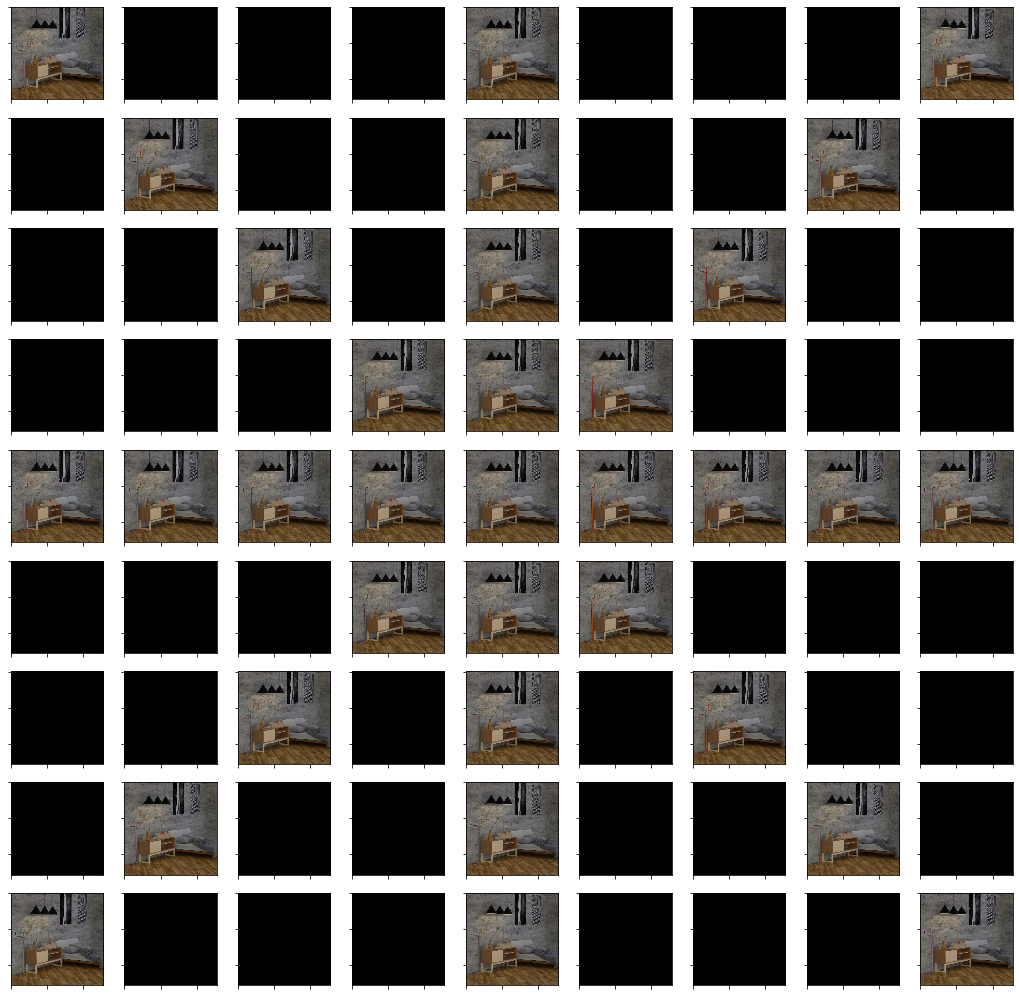

In [2]:
# Show an example image from the test set
show_scene(test_set.load_scene(0))

In [23]:
# Training and testing routines similar to the PyTorch implementation
# but modified for lightfield arrays

device = torch.device("cuda" if use_cuda else "cpu")
model = vae.VAE([400], 20, (512, 512)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Load horizontal lightfield data
# TODO: How to handle different directions
# Todo: Data Augmentation: RandomCrop, RedistColor, Contrast, Brightness, RandomRotate
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, **kwargs)

n_train = len(train_loader.dataset)
n_test = len(test_loader.dataset)
print("Data samples for training:", n_train)
print("Data samples for testing:", n_test)

def train_step(data):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = vae.loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss = loss.item()
    optimizer.step()
    return train_loss
    
def train(epoch, log_interval=1):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        h_views, v_views, i_views, d_views, center, gt, mask, index = data
        #loss_h = train_step(h_views)
        #loss_v = train_step(v_views)
        #train_loss += ((loss_h+loss_v)/2)
        data = h_views.to(device)
        print(data.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))



Data samples for training: 27
Data samples for testing: 1


In [24]:
# Train the model for some epochs and run the test
for epoch in range(1, 31):
    train(epoch, log_interval=5)

torch.Size([1, 9, 3, 512, 512])


RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 7.76 GiB total capacity; 6.03 GiB already allocated; 129.25 MiB free; 6.34 GiB reserved in total by PyTorch)

In [1]:
# Test
model.eval()
test_loss = 0
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, **kwargs)
with torch.no_grad():
    for i, data in enumerate(test_loader):
        h_views, v_views, i_views, d_views, center, gt, mask, index = data
        data_h = h_views[0].to(device)
        data_v = v_views[0].to(device)
        mu_h, var_h = model.encode(data_h.view(-1, 512*512))
        mu_v, var_v = model.encode(data_v.view(-1, 512*512))
        z_h, z_v = model.reparameterize(mu_h, var_h), model.reparameterize(mu_v, var_v)
        predicted = model.decode(z_h + z_v)
        test_loss += F.l1_loss(predicted, d_views[0].to(device).view(-1, 512*512))
        if i == 0:
            print("True decreasing diagonal:")
            show_view_sequence(d_views[0])
            print("Predicted:")
            show_view_sequence(predicted.cpu().view(9, 3, 512, 512), save=True)

test_loss /= len(test_loader.dataset)
print('====> Test set loss: {:.4f}'.format(test_loss))

NameError: name 'model' is not defined

## Deprecated stuff
Just for testing purposes

In [15]:
# Load horizontal lightfield data
# TODO: How to handle different directions
from dataloaders.lightfield_loader import LightfieldLoader
train_loader = LightfieldLoader(train_set, scene_idx=0, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

print("Data samples for training:", len(train_loader.dataset))
print("Data samples for testing:", len(test_loader.dataset))

def train(epoch, log_interval=2):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        print(data.shape)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))




Data samples for training: 18
Data samples for testing: 18


In [16]:
for epoch in range(1, 11):
    train(epoch)


torch.Size([1, 3, 512, 512])
Train Epoch: 1 [0/18 (0%)]	Loss: 542475.250000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [2/18 (11%)]	Loss: 550538.875000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [4/18 (22%)]	Loss: 541181.562500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [6/18 (33%)]	Loss: 535009.437500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [8/18 (44%)]	Loss: 530614.187500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [10/18 (56%)]	Loss: 527651.375000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [12/18 (67%)]	Loss: 527541.375000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [14/18 (78%)]	Loss: 526375.937500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 1 [16/18 (89%)]	Loss: 522899.406250
torch.Size([1, 3, 512, 512])
====> Epoch: 1 Average loss: 533095.5486
to

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [6/18 (33%)]	Loss: 494532.468750
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [8/18 (44%)]	Loss: 490401.437500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [10/18 (56%)]	Loss: 492828.593750
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [12/18 (67%)]	Loss: 490247.375000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [14/18 (78%)]	Loss: 492994.375000
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 9 [16/18 (89%)]	Loss: 489896.593750
torch.Size([1, 3, 512, 512])
====> Epoch: 9 Average loss: 492178.7517
torch.Size([1, 3, 512, 512])
Train Epoch: 10 [0/18 (0%)]	Loss: 493570.718750
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 10 [2/18 (11%)]	Loss: 490836.687500
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
Train Epoch: 10 [4/18 (22%)]	Loss: 493044.062500

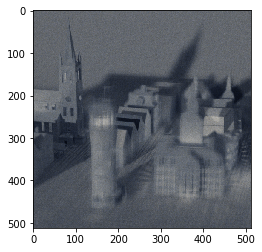

====> Test set loss: 520744.6267


In [17]:
from dataloaders.lightfield_loader import LightfieldLoader
test_loader = LightfieldLoader(test_set, scene_idx=0, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae.loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                img = recon_batch.view(BATCH_SIZE, 3, 512, 512)[0].cpu()
                img = np.stack((img[0], img[1], img[2]), axis=-1)
                plt.imshow(img)
                plt.show()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
test(0)